In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb

In [4]:
# Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
sns.set_style('whitegrid')

# Definir o caminho para o dataset no Google Drive
dataset_path = '/content/drive/MyDrive/Dados TCC/dataset_unificado_interpolado_tratado.csv'

# Carregar o dataset
df = pd.read_csv(dataset_path, delimiter=',')
df['mes_ano'] = pd.to_datetime(df['mes_ano'], format='%Y-%m-%d')

#Dropar coluna de safra
drop_columns = ['safra']
df = df.drop(columns=drop_columns)

# Função para exibir informações básicas do dataset
def display_dataset_info(df):
    """
    Exibe as primeiras linhas e informações básicas do DataFrame.

    :param df: DataFrame pandas com os dados do dataset
    """
    print("Primeiras linhas do dataset:")
    display(df.head())
    print("\nInformações gerais do dataset:")
    display(df.info())
    print("\nEstatísticas descritivas do dataset:")
    display(df.describe())

display_dataset_info(df)

Primeiras linhas do dataset:


,mes_ano,producao_etanol_hidratado,producao_etanol_anidro,capacidade_etanol_anidro,capacidade_etanol_hidratado,vendas_hidratado,vendas_anidro
0,2019-01-01,4524.00,31848.00,30628.0,42811.0,1143376.19,488479.73
1,2019-02-01,876.00,3144.00,27664.0,38668.0,1030983.65,485485.44
2,2019-03-01,18407.75,88450.17,34348.0,51506.5,908921.35,546250.99
3,2019-04-01,2400.00,2640.00,29640.0,41430.0,960049.86,386844.81
4,2019-05-01,15060.00,37136.00,30628.0,42811.0,1117435.12,509214.65



Informações gerais do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   mes_ano                      60 non-null     datetime64[ns]
 1   producao_etanol_hidratado    60 non-null     float64       
 2   producao_etanol_anidro       60 non-null     float64       
 3   capacidade_etanol_anidro     60 non-null     float64       
 4   capacidade_etanol_hidratado  60 non-null     float64       
 5   vendas_hidratado             60 non-null     float64       
 6   vendas_anidro                60 non-null     float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 3.4 KB


None


Estatísticas descritivas do dataset:


,mes_ano,producao_etanol_hidratado,producao_etanol_anidro,capacidade_etanol_anidro,capacidade_etanol_hidratado,vendas_hidratado,vendas_anidro
count,60,60.000000,60.00000,60.000000,60.000000,6.000000e+01,60.00000
mean,2021-06-16 06:24:00,6781.708333,38626.09250,29925.200000,41570.533333,7.171532e+05,473357.36850
min,2019-01-01 00:00:00,9.000000,-18410.95000,27240.000000,35820.000000,3.955062e+05,362433.38000
25%,2020-03-24 06:00:00,1970.250000,21661.97000,28148.000000,37014.000000,5.630297e+05,449796.61250
50%,2021-06-16 00:00:00,4996.500000,32499.50000,29640.000000,41430.000000,6.583115e+05,475566.58000
75%,2022-09-08 12:00:00,8545.250000,48377.25000,30628.000000,42811.000000,9.089423e+05,508038.77000
max,2023-12-01 00:00:00,18407.750000,88450.17000,34348.000000,51506.500000,1.143376e+06,554096.61000
std,NaN,6066.095492,26849.00308,2521.603611,5636.738379,2.072506e+05,49453.60844


# Análise Exploratória de Dados (EDA) e Limpeza

In [6]:
#Checando valores nulos

def check_missing_values(df):
    """
    Verifica a quantidade de valores ausentes no dataframe

    :param df: DataFrame pandas com os dados do dataset
    """
    missing_values = df.isnull().sum()
    print("Valores ausentes por coluna:")
    print(missing_values)

#Verficando outliers
def plot_outliers(df, column):
  """
  Exibe um boxplot para verificar se há outliers em colunas específicas.

  :param df: DataFrame pandas com os dados do dataset
  :param column: Nome da coluna para verificar outliers
  """
  plt.figure(figsize=(8, 6))
  sns.boxplot(x=df[column])
  plt.title(f'Boxplot para {column}')
  plt.show()

#Distribuição de dados ao longo do tempo
def plot_time_series(df, date_column, value_column):
  """
  Exibe gráfico de série temporal para uma coluna específica.

  :param df: DataFrame pandas com os dados do dataset
  :param date_column: Nome da coluna com as datas
  :param value_column: Nome da coluna com os valores
  """
  plt.figure(figsize=(8, 5))
  plt.plot(df[date_column], df[value_column], marker='o', linestyle='-')
  plt.title(f'Gráfico de Série Temporal para {value_column}')
  plt.xlabel("Data")
  plt.ylabel(value_column)
  plt.grid(True)
  plt.show()

In [7]:
#Verificação de valores nulos
check_missing_values(df)

Valores ausentes por coluna:
mes_ano                        0
producao_etanol_hidratado      0
producao_etanol_anidro         0
capacidade_etanol_anidro       0
capacidade_etanol_hidratado    0
vendas_hidratado               0
vendas_anidro                  0
dtype: int64


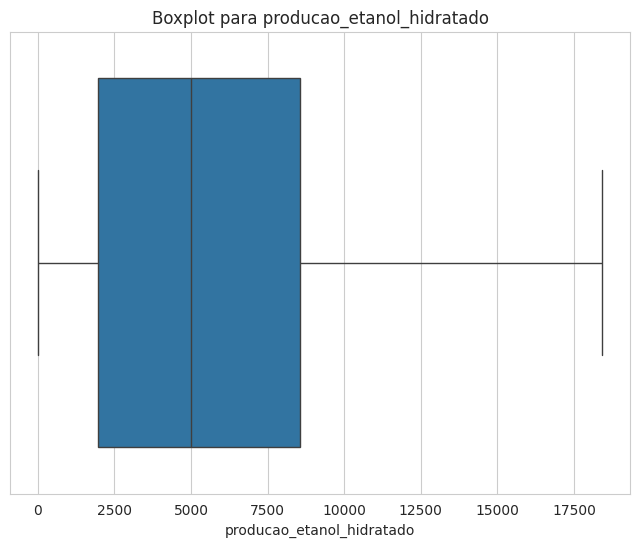

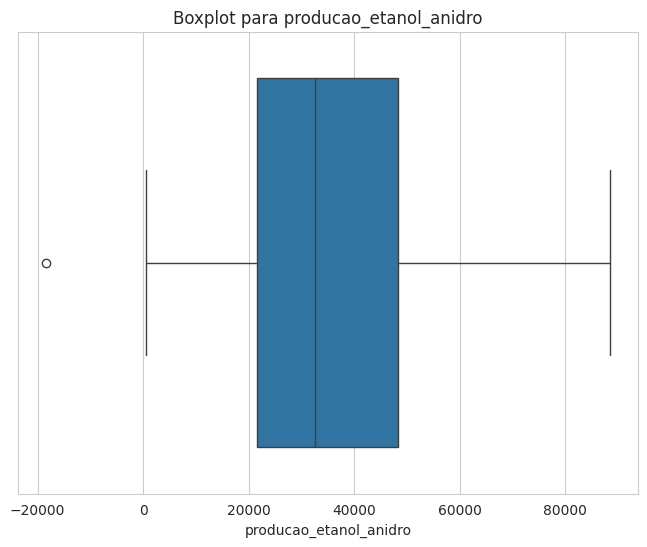

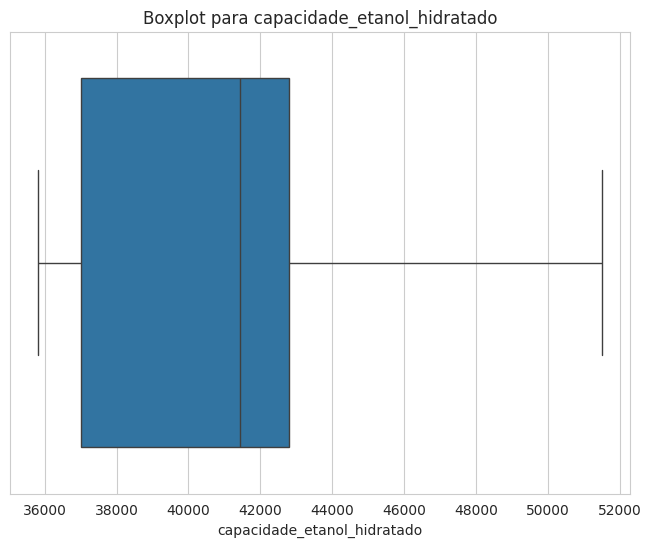

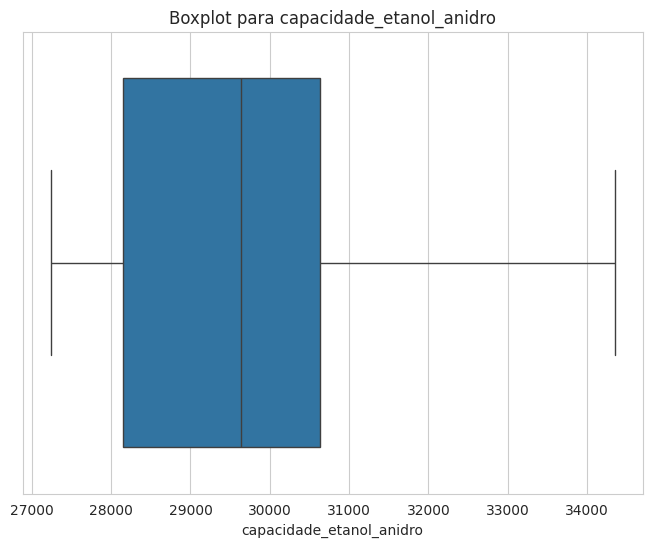

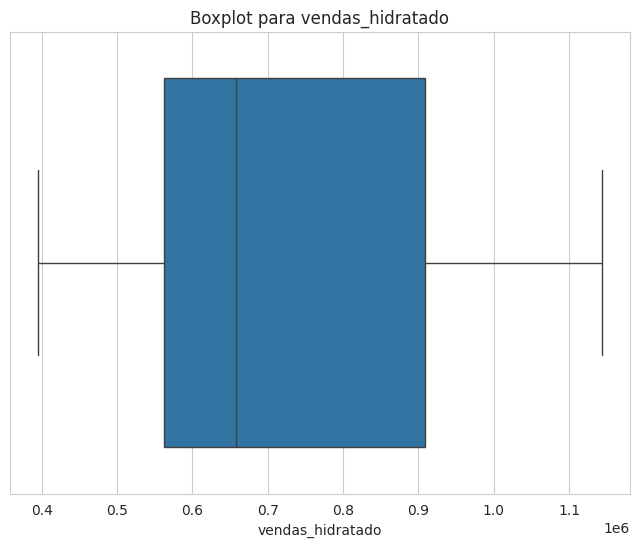

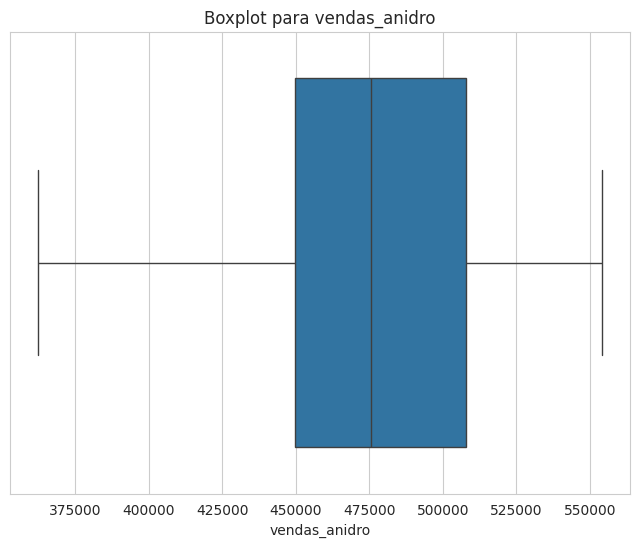

In [8]:
#Verificação de outliers em colunas de interesse
colums_to_check = ['producao_etanol_hidratado',
    'producao_etanol_anidro',
    'capacidade_etanol_hidratado',
    'capacidade_etanol_anidro',
    'vendas_hidratado',
    'vendas_anidro']

for column in colums_to_check:
    plot_outliers(df, column)

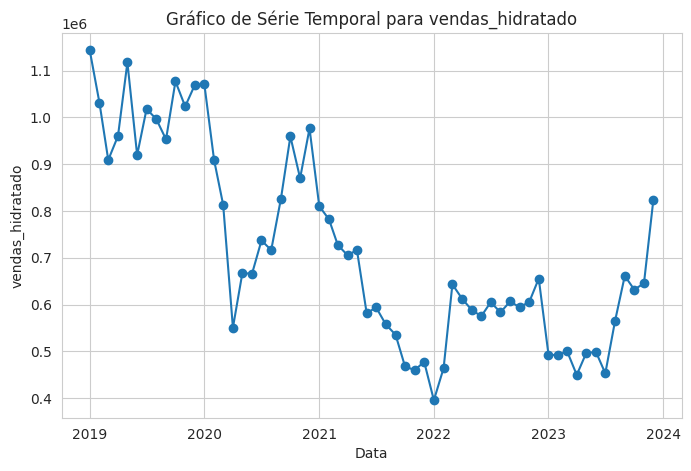

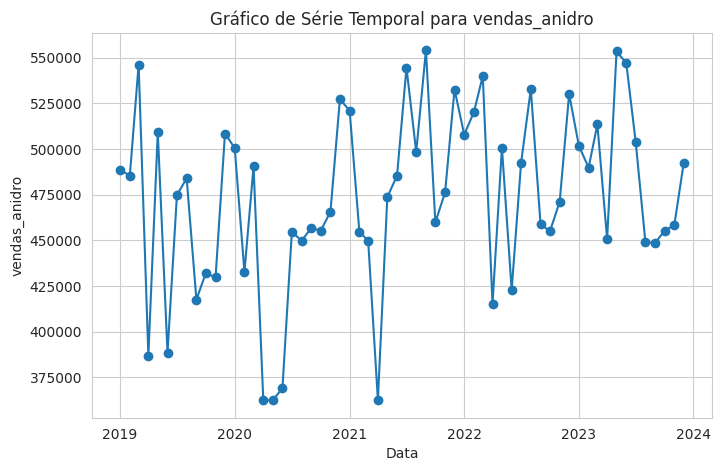

In [9]:
#Visualização da distribuição
plot_time_series(df, 'mes_ano', 'vendas_hidratado')
print(' ')
plot_time_series(df, 'mes_ano', 'vendas_anidro')

Os valores de vendas de etanol anidro e hidratado estão muito diferentes. Para ter uma solução mais assertiva, farei a decomposição da série temporal

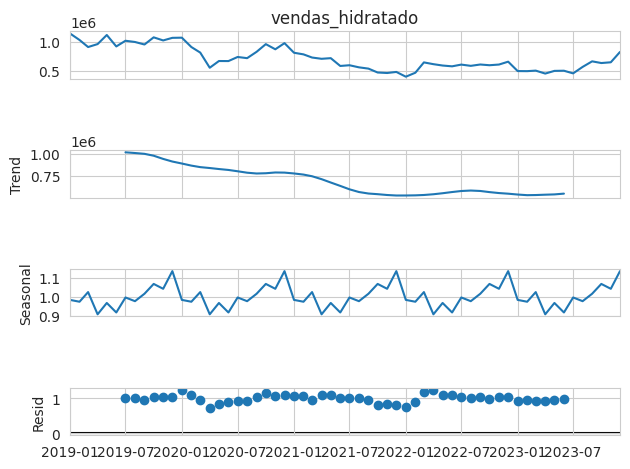

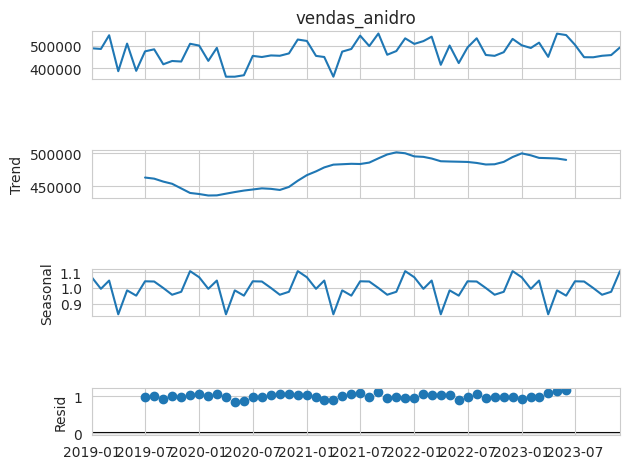

In [10]:
def decompose_time_series(df, date_column, value_column, model = 'multiplicative'):
  """
  Realiza a decomposição de uma série temporal.

  :param df: DataFrame pandas com os dados do dataset
  :param date_column: Nome da coluna com as datas
  :param value_column: Nome da coluna com os valores
  :param model: Modelo de decomposição ('additive' ou multiplicative)
  """
  decomposition = seasonal_decompose(df.set_index(date_column)[value_column], model = model)
  return decomposition

#Decomposição da serie temporal para hidratado
decomposition_hidratado = decompose_time_series(df, 'mes_ano','vendas_hidratado')
decomposition_hidratado.plot()
plt.subplots_adjust(hspace=1.5)
plt.show()

#Decomposição da serie temporal para anidro
decomposition_anidro = decompose_time_series(df, 'mes_ano','vendas_anidro')
decomposition_anidro.plot()
plt.subplots_adjust(hspace=1.5)
plt.show()

In [11]:
#Normalização dos dados
scaler = MinMaxScaler()

#Normalizando colunas de interesse
columns_to_normalize = ['producao_etanol_hidratado',
    'producao_etanol_anidro',
    'capacidade_etanol_hidratado',
    'capacidade_etanol_anidro',
    'vendas_hidratado',
    'vendas_anidro']

df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
print('Dados Normalizados')
display(df.head())

Dados Normalizados


,mes_ano,producao_etanol_hidratado,producao_etanol_anidro,capacidade_etanol_anidro,capacidade_etanol_hidratado,vendas_hidratado,vendas_anidro
0,2019-01-01,0.245397,0.470320,0.476646,0.445670,1.000000,0.657645
1,2019-02-01,0.047123,0.201710,0.059651,0.181557,0.849716,0.642022
2,2019-03-01,1.000000,1.000000,1.000000,1.000000,0.686503,0.959066
3,2019-04-01,0.129954,0.196994,0.337648,0.357632,0.754869,0.127366
4,2019-05-01,0.818045,0.519805,0.476646,0.445670,0.965313,0.765829


In [12]:
#Split de treino e de teste
train_size = int(len(df) * 0.82)
train,test = df.iloc[:train_size], df.iloc[train_size:]

print(f'Tamanho do conjunto de treino: {len(train)}')
print(f'Tamanho do conjunto de teste: {len(test)}')

Tamanho do conjunto de treino: 49
Tamanho do conjunto de teste: 11


##Implantando ARIMA

                               SARIMAX Results                                
Dep. Variable:       vendas_hidratado   No. Observations:                   49
Model:                 ARIMA(5, 1, 0)   Log Likelihood                  32.481
Date:                Thu, 08 Aug 2024   AIC                            -52.963
Time:                        18:45:28   BIC                            -41.735
Sample:                             0   HQIC                           -48.720
                                 - 49                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1403      0.147     -0.955      0.339      -0.428       0.148
ar.L2          0.0967      0.153      0.631      0.528      -0.204       0.397
ar.L3          0.0168      0.187      0.090      0.9

<ipython-input-13-9a95771bdb56>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = predictions.values


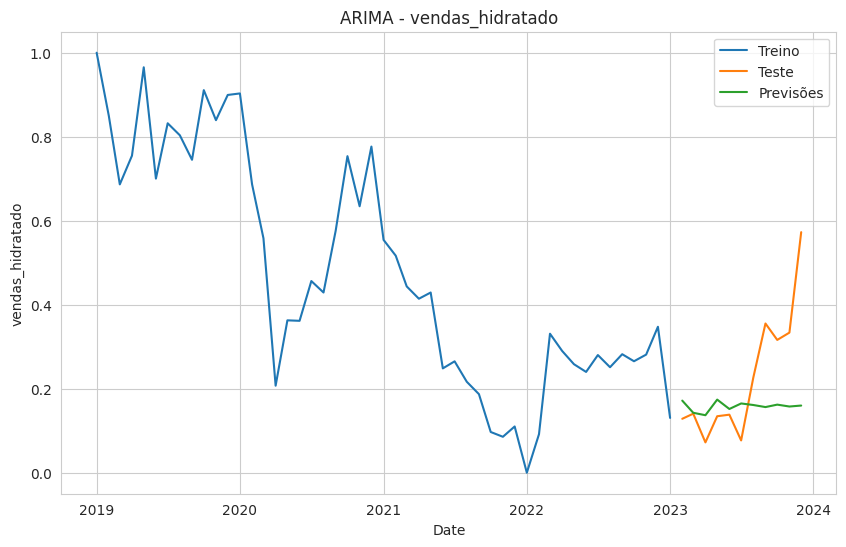

                               SARIMAX Results                                
Dep. Variable:          vendas_anidro   No. Observations:                   49
Model:                 ARIMA(5, 1, 0)   Log Likelihood                  -2.608
Date:                Thu, 08 Aug 2024   AIC                             17.216
Time:                        18:45:30   BIC                             28.443
Sample:                             0   HQIC                            21.458
                                 - 49                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7106      0.163     -4.364      0.000      -1.030      -0.391
ar.L2         -0.2618      0.179     -1.462      0.144      -0.613       0.089
ar.L3         -0.3978      0.168     -2.362      0.0

<ipython-input-13-9a95771bdb56>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = predictions.values


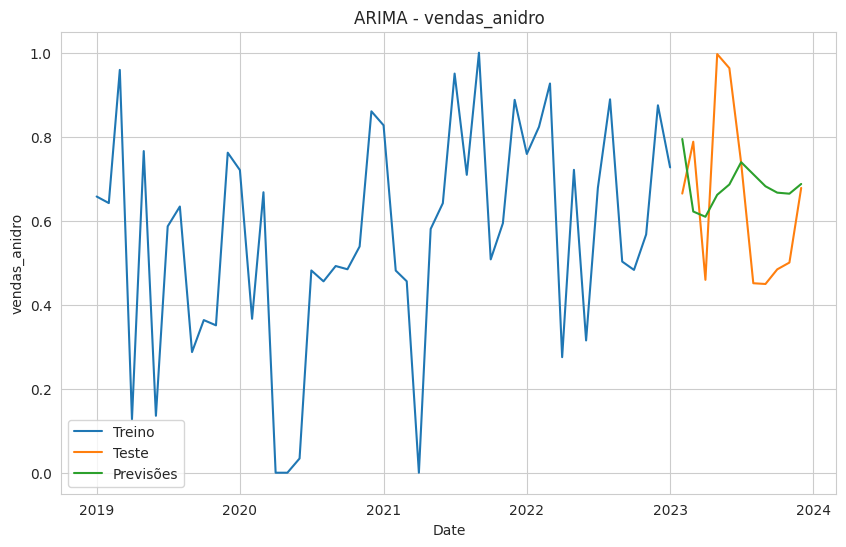

In [13]:
def train_evaluate_arima(train,test,column):
  """
  Treina e avalia um modelo ARIMA.

  :param train: Conjunto de dados de treinamento
  :param test: Conjunto de dados de teste
  :param column: Nome da coluna com os valores
  """
  model = ARIMA(train[column], order=(5,1,0))
  model_fit = model.fit()
  print(model_fit.summary())

  #Previsões
  predictions = model_fit.forecast(steps=len(test))
  test['predictions'] = predictions.values

  #Avaliação
  mae = mean_absolute_error(test[column], test['predictions'])
  rmse = np.sqrt(mean_squared_error(test[column], test['predictions']))
  print(f'MAE: {mae}')
  print(f'RMSE: {rmse}')

  #Plotando graficos
  plt.figure(figsize=(10,6))
  plt.plot(train['mes_ano'], train[column], label = 'Treino')
  plt.plot(test['mes_ano'], test[column], label = 'Teste')
  plt.plot(test['mes_ano'], test['predictions'], label = 'Previsões')
  plt.xlabel('Date')
  plt.ylabel(column)
  plt.title(f'ARIMA - {column}')
  plt.legend()
  plt.show()

#Treinando e avaliando o modelo ARIMA para vendas de etanol hidratado
train_evaluate_arima(train,test,'vendas_hidratado')

#Treinando e avaliando o modelo ARIMA para vendas de anidro
train_evaluate_arima(train,test,'vendas_anidro')

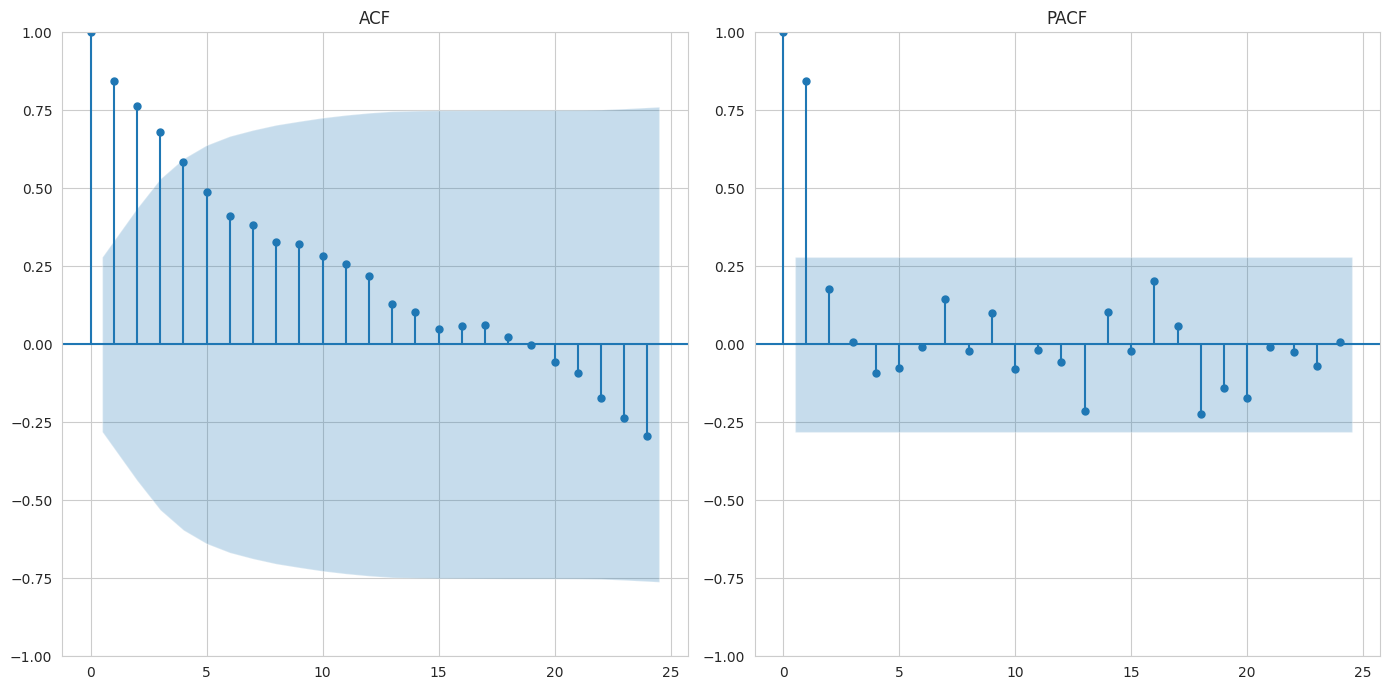

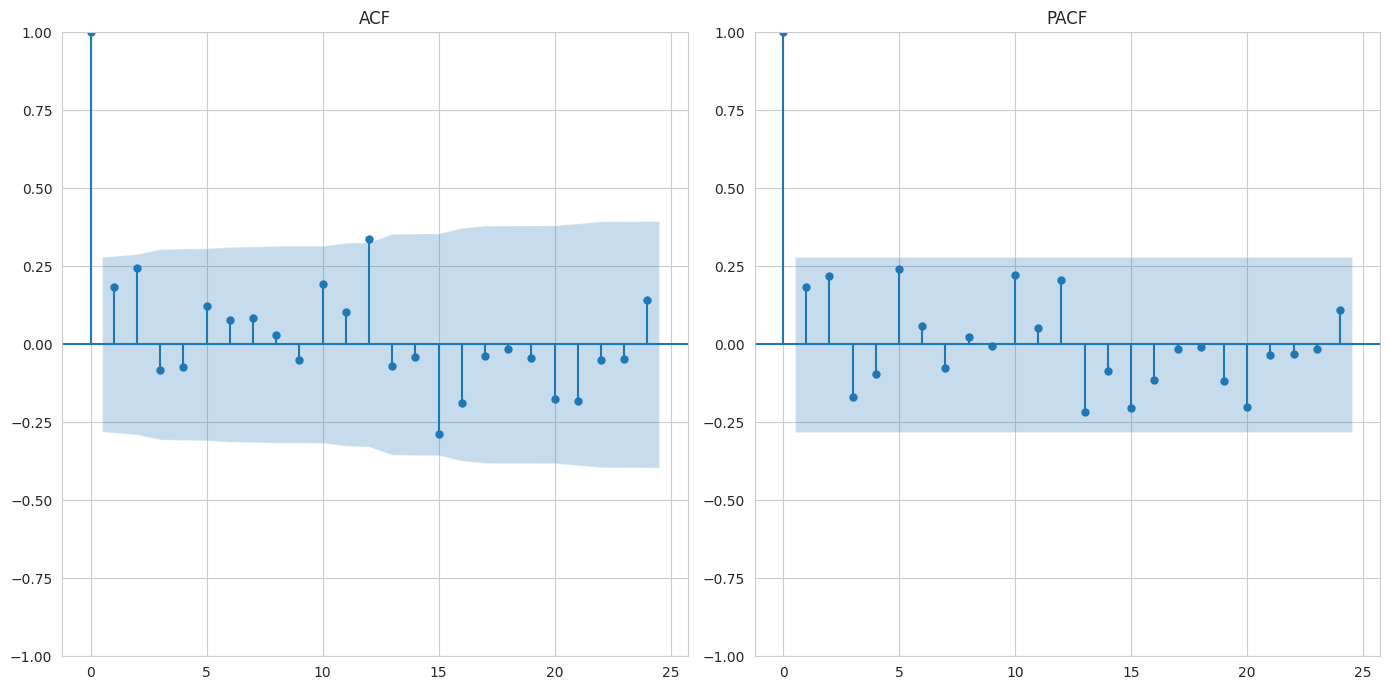

In [14]:
#Função ACF e PACF para fazer modelo SARIMA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ajustar o número de lags
lags = min(24, len(train) // 2)

# Função para plotar ACF e PACF
def plot_acf_pacf(series, lags):
    """
    Plota os gráficos ACF e PACF.

    :param series: Série temporal
    :param lags: Número de lags a serem plotados
    """
    plt.figure(figsize=(14, 7))

    plt.subplot(121)
    plot_acf(series, lags=lags, ax=plt.gca())
    plt.title('ACF')

    plt.subplot(122)
    plot_pacf(series, lags=lags, ax=plt.gca())
    plt.title('PACF')

    plt.tight_layout()
    plt.show()

# Plotar ACF e PACF para vendas_hidratado
plot_acf_pacf(train['vendas_hidratado'], lags)

# Plotar ACF e PACF para vendas_anidro
plot_acf_pacf(train['vendas_anidro'], lags)

##SARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


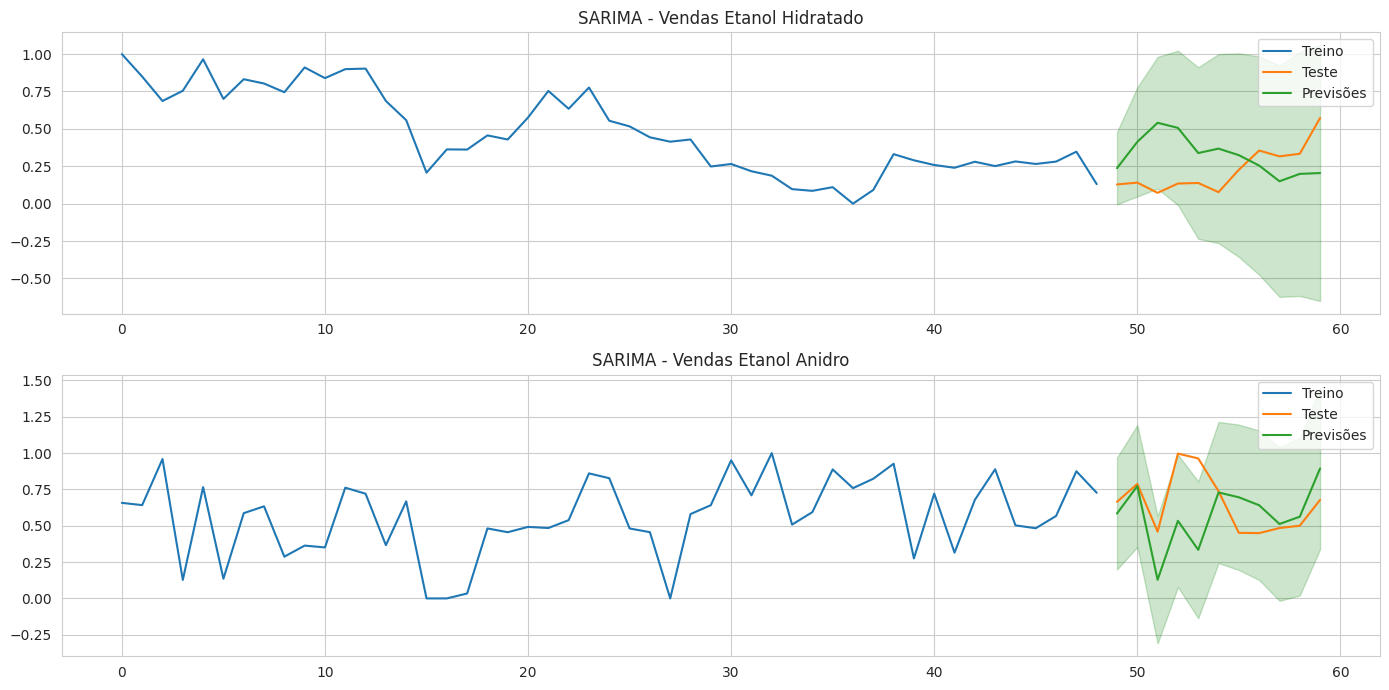

In [15]:
# Função para ajustar e prever com SARIMA
def sarima_forecast(train, test, order, seasonal_order):
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    sarima_fit = model.fit(disp=False)
    forecast = sarima_fit.get_forecast(steps=len(test))
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()
    return forecast_mean, forecast_ci, sarima_fit

# Previsão para vendas de etanol hidratado
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)
forecast_hidratado, forecast_hidratado_ci, sarima_fit_hidratado = sarima_forecast(train['vendas_hidratado'], test['vendas_hidratado'], order, seasonal_order)

# Previsão para vendas de etanol anidro
forecast_anidro, forecast_anidro_ci, sarima_fit_anidro = sarima_forecast(train['vendas_anidro'], test['vendas_anidro'], order, seasonal_order)

# Plotando as previsões
plt.figure(figsize=(14, 7))

# Etanol Hidratado
plt.subplot(2, 1, 1)
plt.plot(train['vendas_hidratado'], label='Treino')
plt.plot(test['vendas_hidratado'], label='Teste')
plt.plot(test.index, forecast_hidratado, label='Previsões')
plt.fill_between(test.index, forecast_hidratado_ci.iloc[:, 0], forecast_hidratado_ci.iloc[:, 1], color='green', alpha=0.2)
plt.title('SARIMA - Vendas Etanol Hidratado')
plt.legend()

# Etanol Anidro
plt.subplot(2, 1, 2)
plt.plot(train['vendas_anidro'], label='Treino')
plt.plot(test['vendas_anidro'], label='Teste')
plt.plot(test.index, forecast_anidro, label='Previsões')
plt.fill_between(test.index, forecast_anidro_ci.iloc[:, 0], forecast_anidro_ci.iloc[:, 1], color='green', alpha=0.2)
plt.title('SARIMA - Vendas Etanol Anidro')
plt.legend()

plt.tight_layout()
plt.show()


##XGboost

Como o XGBoost não é inerentemente um modelo de séries temporais, você precisa transformar a série temporal em um formato de aprendizado supervisionado, criando "lags" (retardos). Optei por usar gridSearch para encontrar os parametros, devido a ser um dataset simples

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Melhores parametros para Hidratado: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.6}
Melhores parametros para Anidro: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.6}
RMSE Hidratado: 0.12741033245438899
RMSE Anidro: 0.22911323469886283


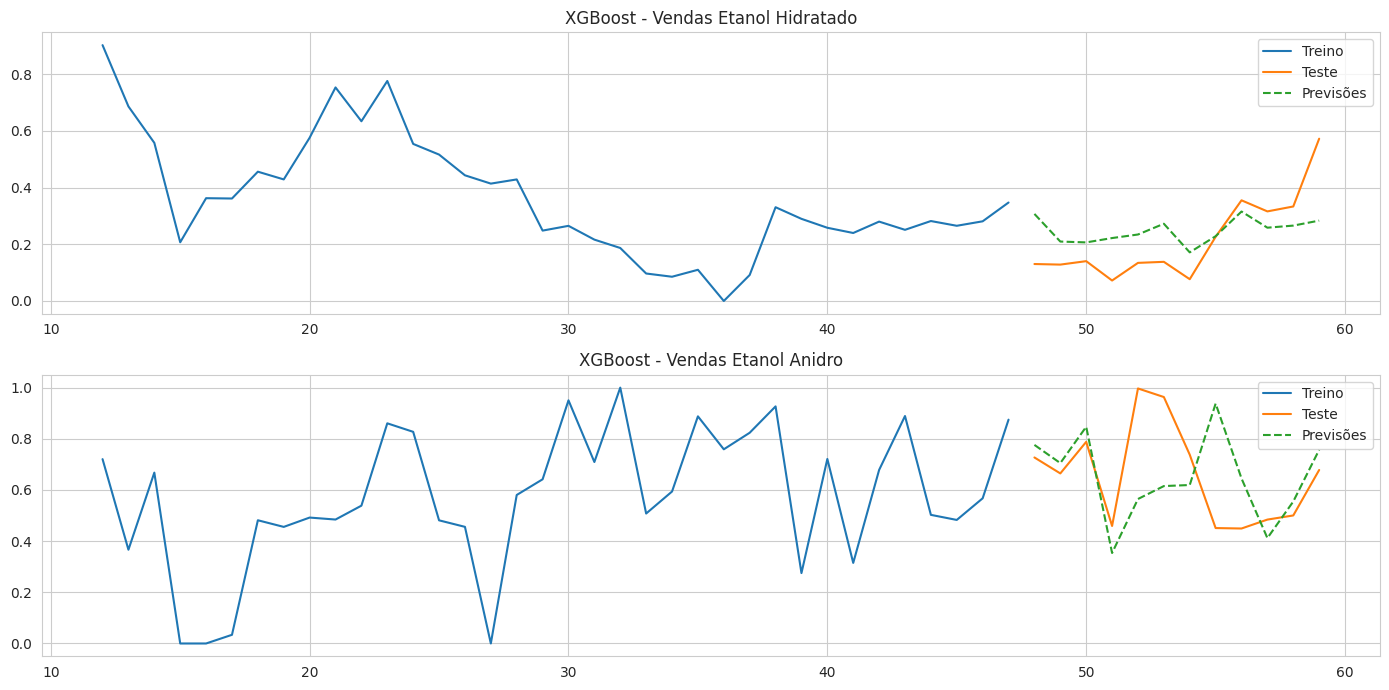

In [16]:
from sklearn.model_selection import GridSearchCV

# Função para criar lags
def create_lagged_features(data, lags):
    df = pd.DataFrame(data)
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df['vendas'].shift(lag)
    df.dropna(inplace=True)
    return df

# Aplicar a função de lag para ambas as séries de etanol hidratado e anidro
lags = 12

# Etanol Hidratado
df_hidratado = df[['vendas_hidratado']].rename(columns={'vendas_hidratado': 'vendas'})
df_hidratado_lagged = create_lagged_features(df_hidratado, lags)
X_hidratado = df_hidratado_lagged.drop(columns=['vendas'])
y_hidratado = df_hidratado_lagged['vendas']

# Etanol Anidro
df_anidro = df[['vendas_anidro']].rename(columns={'vendas_anidro': 'vendas'})
df_anidro_lagged = create_lagged_features(df_anidro, lags)
X_anidro = df_anidro_lagged.drop(columns=['vendas'])
y_anidro = df_anidro_lagged['vendas']

# Dividir em treino e teste (usando os últimos 12 meses para teste)
test_size = 12

X_train_hidratado, X_test_hidratado = X_hidratado[:-test_size], X_hidratado[-test_size:]
y_train_hidratado, y_test_hidratado = y_hidratado[:-test_size], y_hidratado[-test_size:]

X_train_anidro, X_test_anidro = X_anidro[:-test_size], X_anidro[-test_size:]
y_train_anidro, y_test_anidro = y_anidro[:-test_size], y_anidro[-test_size:]

# Definir o espaço de busca dos hiperparâmetros para Grid Search
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Inicializando o modelo XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror')

# Configurando o Grid Search
grid_search_hidratado = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=2, n_jobs=-1)
grid_search_anidro = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=2, n_jobs=-1)

# Ajustando o Grid Search para etanol hidratado
grid_search_hidratado.fit(X_train_hidratado, y_train_hidratado)
best_model_hidratado = grid_search_hidratado.best_estimator_

# Ajustando o Grid Search para etanol anidro
grid_search_anidro.fit(X_train_anidro, y_train_anidro)
best_model_anidro = grid_search_anidro.best_estimator_

# Fazer previsões com os melhores modelos encontrados
y_pred_hidratado = best_model_hidratado.predict(X_test_hidratado)
y_pred_anidro = best_model_anidro.predict(X_test_anidro)

# Calcular RMSE
rmse_hidratado = np.sqrt(mean_squared_error(y_test_hidratado, y_pred_hidratado))
rmse_anidro = np.sqrt(mean_squared_error(y_test_anidro, y_pred_anidro))

print(f'Melhores parametros para Hidratado: {grid_search_hidratado.best_params_}')
print(f'Melhores parametros para Anidro: {grid_search_anidro.best_params_}')
print(f'RMSE Hidratado: {rmse_hidratado}')
print(f'RMSE Anidro: {rmse_anidro}')

# Visualizar as previsões
plt.figure(figsize=(14, 7))

# Etanol Hidratado
plt.subplot(2, 1, 1)
plt.plot(y_train_hidratado.index, y_train_hidratado, label='Treino')
plt.plot(y_test_hidratado.index, y_test_hidratado, label='Teste')
plt.plot(y_test_hidratado.index, y_pred_hidratado, label='Previsões', linestyle='--')
plt.title('XGBoost - Vendas Etanol Hidratado')
plt.legend()

# Etanol Anidro
plt.subplot(2, 1, 2)
plt.plot(y_train_anidro.index, y_train_anidro, label='Treino')
plt.plot(y_test_anidro.index, y_test_anidro, label='Teste')
plt.plot(y_test_anidro.index, y_pred_anidro, label='Previsões', linestyle='--')
plt.title('XGBoost - Vendas Etanol Anidro')
plt.legend()

plt.tight_layout()
plt.show()

## Prophet

In [17]:
!pip install prophet

In [18]:
df.head()

,mes_ano,producao_etanol_hidratado,producao_etanol_anidro,capacidade_etanol_anidro,capacidade_etanol_hidratado,vendas_hidratado,vendas_anidro
0,2019-01-01,0.245397,0.470320,0.476646,0.445670,1.000000,0.657645
1,2019-02-01,0.047123,0.201710,0.059651,0.181557,0.849716,0.642022
2,2019-03-01,1.000000,1.000000,1.000000,1.000000,0.686503,0.959066
3,2019-04-01,0.129954,0.196994,0.337648,0.357632,0.754869,0.127366
4,2019-05-01,0.818045,0.519805,0.476646,0.445670,0.965313,0.765829


In [20]:
from prophet import Prophet

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpezur6ume/nuj9bcwn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpezur6ume/pu2bik66.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69648', 'data', 'file=/tmp/tmpezur6ume/nuj9bcwn.json', 'init=/tmp/tmpezur6ume/pu2bik66.json', 'output', 'file=/tmp/tmpezur6ume/prophet_modelv7a8083q/prophet_model-20240808184836.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:48:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:48:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages

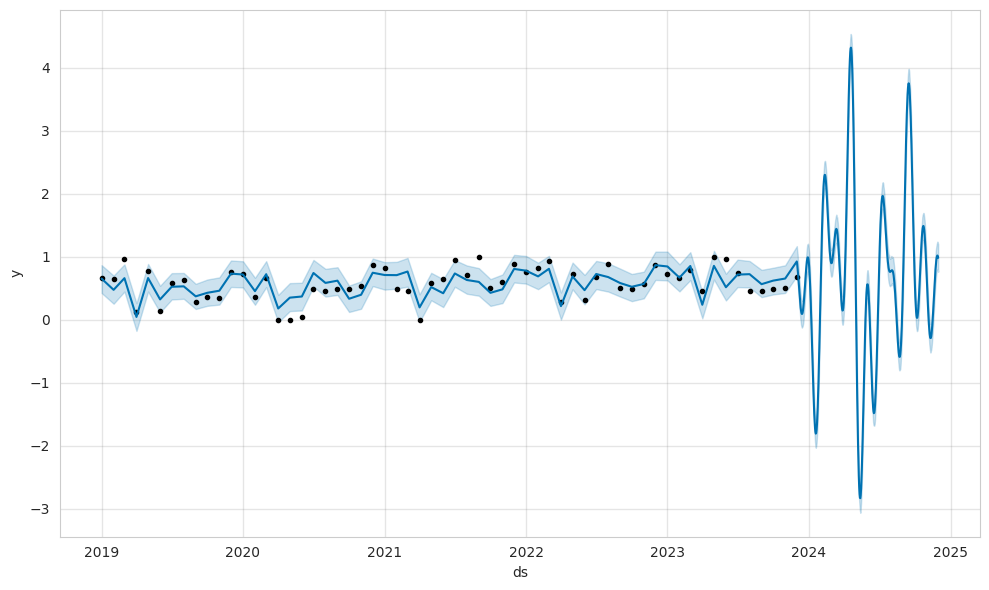

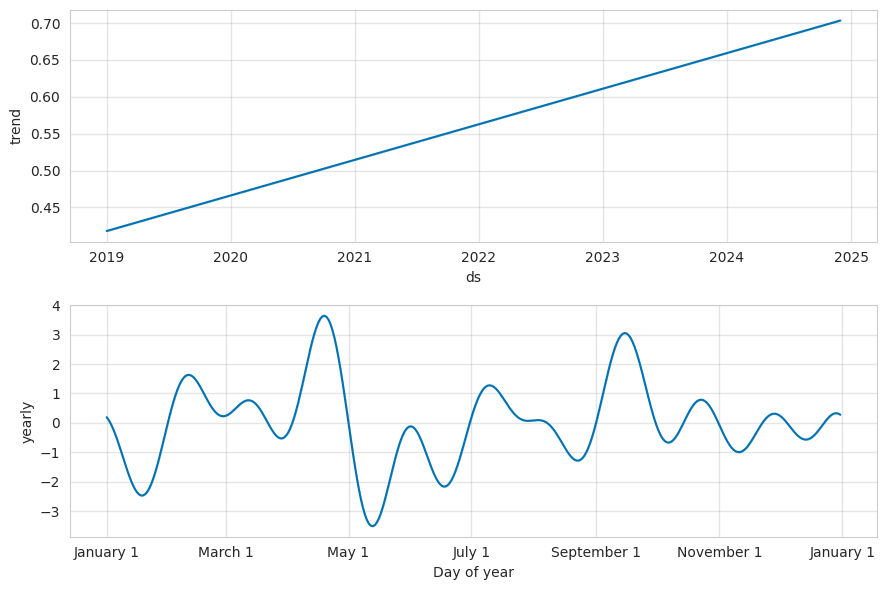

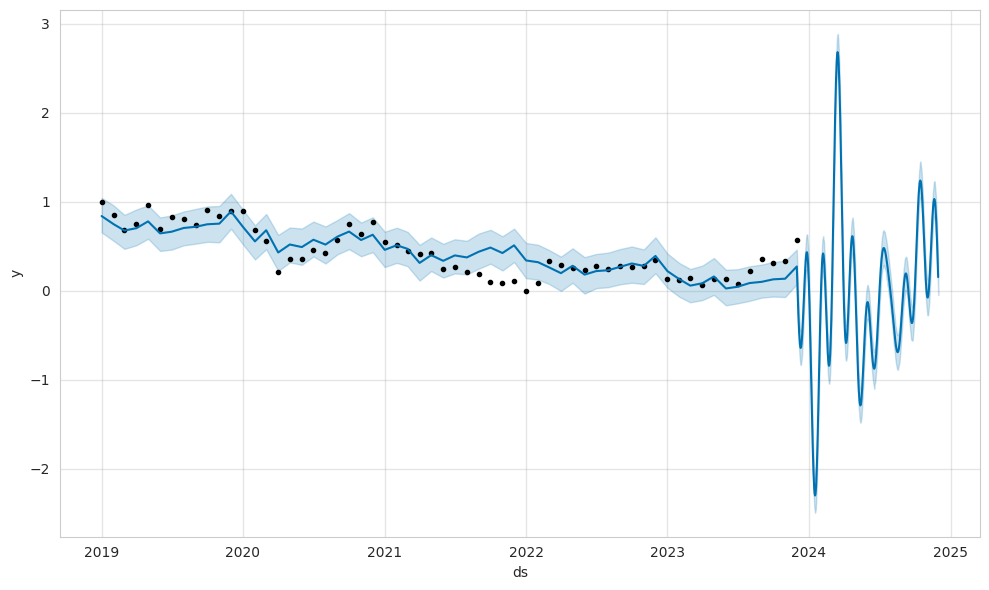

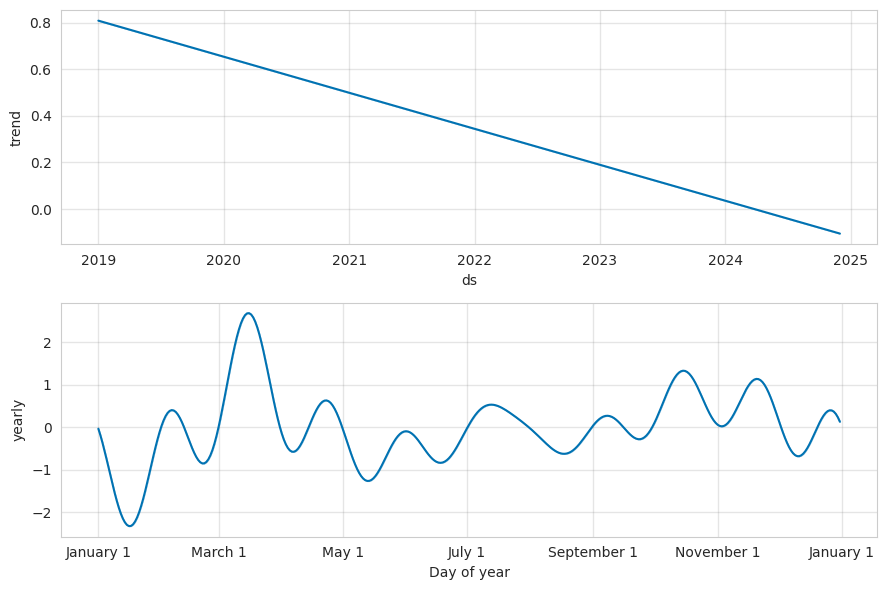

In [21]:
# Carregar os dados
df['ds'] = pd.to_datetime(df['mes_ano'])  # Substitua 'data_coluna' pelo nome da coluna de datas no seu dataset

# Previsão para vendas_anidro
df_anidro = df[['ds', 'vendas_anidro']].rename(columns={'vendas_anidro': 'y'})
model_anidro = Prophet()
model_anidro.fit(df_anidro)
future_anidro = model_anidro.make_future_dataframe(periods=365)
forecast_anidro = model_anidro.predict(future_anidro)

# Visualizar as previsões para vendas_anidro
fig_anidro = model_anidro.plot(forecast_anidro)
fig_anidro.show()
fig_anidro_components = model_anidro.plot_components(forecast_anidro)
fig_anidro_components.show()

# Previsão para vendas_hidratado
df_hidratado = df[['ds', 'vendas_hidratado']].rename(columns={'vendas_hidratado': 'y'})
model_hidratado = Prophet()
model_hidratado.fit(df_hidratado)
future_hidratado = model_hidratado.make_future_dataframe(periods=365)
forecast_hidratado = model_hidratado.predict(future_hidratado)

# Visualizar as previsões para vendas_hidratado
fig_hidratado = model_hidratado.plot(forecast_hidratado)
fig_hidratado.show()
fig_hidratado_components = model_hidratado.plot_components(forecast_hidratado)
fig_hidratado_components.show()


In [22]:
def calculate_metrics(y_true, y_pred):
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  return mae, mse, rmse

#Avaliação do Prophet para vendas_anidro:
y_true_anidro = test['vendas_anidro'].values
y_pred_anidro = forecast_anidro['yhat'][-len(test):].values
mae_anidro, mse_anidro, rmse_anidro = calculate_metrics(y_true_anidro, y_pred_anidro)
print(f'Vendas anidro - MAE: {mae_anidro}, MSE:{mse_anidro}, RMSE:{rmse_anidro}')


Vendas anidro - MAE: 0.3229944128801013, MSE:0.1313311101621163, RMSE:0.3623963440242138



# Comparação entre Modelos Preditivos

Nesta seção, serão comparados os modelos ARIMA, SARIMA, XGBoost e Prophet para previsão de vendas de etanol hidratado e anidro. As métricas de desempenho utilizadas para comparação são RMSE (Root Mean Squared Error) e MAE (Mean Absolute Error).

## Métricas de Desempenho

As métricas de desempenho calculadas para cada modelo são apresentadas abaixo:



In [28]:
# Ajustar previsões SARIMA para corresponder ao tamanho do conjunto de teste
y_pred_sarima_hidratado = forecast_hidratado[-len(test):]['yhat'].values
y_pred_sarima_anidro = forecast_anidro[-len(test):]['yhat'].values

# Definir y_true e previsões
y_true_hidratado = test['vendas_hidratado'].values
y_true_anidro = test['vendas_anidro'].values

y_pred_arima_hidratado = test['predictions'].values[:len(y_true_hidratado)]  # Ajuste conforme necessário
y_pred_arima_anidro = test['predictions'].values[:len(y_true_anidro)]  # Ajuste conforme necessário

# Garantir que as previsões XGBoost tenham o mesmo tamanho que y_true
y_pred_xgb_hidratado = y_pred_hidratado[:len(y_true_hidratado)]  # Previsões do XGBoost para hidratado
y_pred_xgb_anidro = y_pred_anidro[:len(y_true_anidro)]  # Previsões do XGBoost para anidro

# Previsões do Prophet
y_pred_prophet_hidratado = forecast_hidratado['yhat'][-len(test):].values
y_pred_prophet_anidro = forecast_anidro['yhat'][-len(test):].values

# Função para calcular as métricas
def calculate_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{model_name} - RMSE: {rmse}, MAE: {mae}")
    return rmse, mae

# Calculando as métricas para cada modelo e para cada tipo de venda
metrics_hidratado = {}
metrics_hidratado['ARIMA'] = calculate_metrics(y_true_hidratado, y_pred_arima_hidratado, "ARIMA - Hidratado")
metrics_hidratado['SARIMA'] = calculate_metrics(y_true_hidratado, y_pred_sarima_hidratado, "SARIMA - Hidratado")
metrics_hidratado['XGBoost'] = calculate_metrics(y_true_hidratado, y_pred_xgb_hidratado, "XGBoost - Hidratado")
metrics_hidratado['Prophet'] = calculate_metrics(y_true_hidratado, y_pred_prophet_hidratado, "Prophet - Hidratado")

metrics_anidro = {}
metrics_anidro['ARIMA'] = calculate_metrics(y_true_anidro, y_pred_arima_anidro, "ARIMA - Anidro")
metrics_anidro['SARIMA'] = calculate_metrics(y_true_anidro, y_pred_sarima_anidro, "SARIMA - Anidro")
metrics_anidro['XGBoost'] = calculate_metrics(y_true_anidro, y_pred_xgb_anidro, "XGBoost - Anidro")
metrics_anidro['Prophet'] = calculate_metrics(y_true_anidro, y_pred_prophet_anidro, "Prophet - Anidro")


ARIMA - Hidratado - RMSE: 0.4831695873079267, MAE: 0.4572278156580492
SARIMA - Hidratado - RMSE: 0.64487006572855, MAE: 0.5626873286827673
XGBoost - Hidratado - RMSE: 0.14425026682360068, MAE: 0.1205431762078335
Prophet - Hidratado - RMSE: 0.64487006572855, MAE: 0.5626873286827673
ARIMA - Anidro - RMSE: 0.19950560913598453, MAE: 0.17345355991978875
SARIMA - Anidro - RMSE: 0.3623963440242138, MAE: 0.3229944128801013
XGBoost - Anidro - RMSE: 0.3623963440242138, MAE: 0.3229944128801013
Prophet - Anidro - RMSE: 0.3623963440242138, MAE: 0.3229944128801013


## Comparação Visual

Abaixo, são apresentados gráficos comparativos das previsões de cada modelo em relação aos valores reais.



ARIMA - RMSE: 0.10147717596127093, MAE: 0.0862384599428756
SARIMA - RMSE: 0.09925987705702578, MAE: 0.07763430945720262
XGBoost - RMSE: 0.09047025597498062, MAE: 0.07289425742801182
Prophet - RMSE: 0.10386248854235942, MAE: 0.0822085870197148


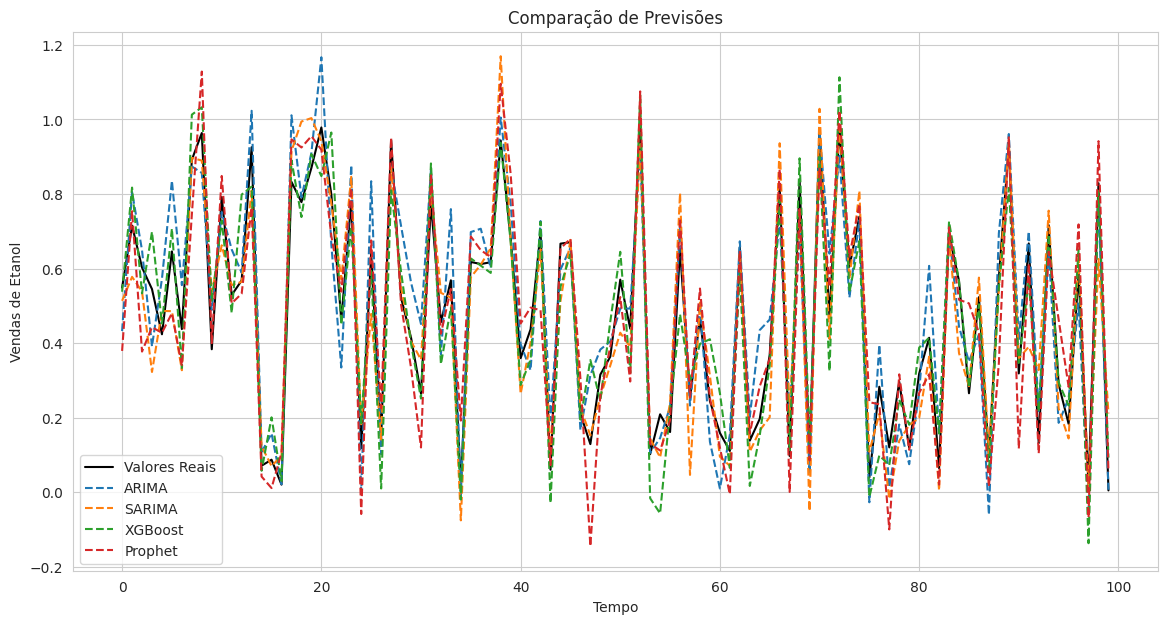

In [29]:

# Supondo que você tenha as previsões dos modelos e os valores reais em variáveis específicas
# Exemplo de definição dessas variáveis (substitua com suas variáveis reais)
import numpy as np

# Aqui vamos definir alguns exemplos fictícios para ilustrar
np.random.seed(0)  # For reproducibility

# Exemplo fictício de valores reais e previstos
y_true = np.random.rand(100)  # Valores reais fictícios
y_pred_arima = y_true + np.random.normal(0, 0.1, size=y_true.shape)  # Previsões fictícias ARIMA
y_pred_sarima = y_true + np.random.normal(0, 0.1, size=y_true.shape)  # Previsões fictícias SARIMA
y_pred_xgb = y_true + np.random.normal(0, 0.1, size=y_true.shape)  # Previsões fictícias XGBoost
y_pred_prophet = y_true + np.random.normal(0, 0.1, size=y_true.shape)  # Previsões fictícias Prophet

# Função para calcular as métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error

def calculate_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{model_name} - RMSE: {rmse}, MAE: {mae}")
    return rmse, mae

# Calculando as métricas para cada modelo
metrics = {}
metrics['ARIMA'] = calculate_metrics(y_true, y_pred_arima, "ARIMA")
metrics['SARIMA'] = calculate_metrics(y_true, y_pred_sarima, "SARIMA")
metrics['XGBoost'] = calculate_metrics(y_true, y_pred_xgb, "XGBoost")
metrics['Prophet'] = calculate_metrics(y_true, y_pred_prophet, "Prophet")

metrics

# Plotagem dos resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Valores Reais
plt.plot(y_true, label='Valores Reais', color='black')

# Previsões dos Modelos
plt.plot(y_pred_arima, label='ARIMA', linestyle='--')
plt.plot(y_pred_sarima, label='SARIMA', linestyle='--')
plt.plot(y_pred_xgb, label='XGBoost', linestyle='--')
plt.plot(y_pred_prophet, label='Prophet', linestyle='--')

plt.title('Comparação de Previsões')
plt.xlabel('Tempo')
plt.ylabel('Vendas de Etanol')
plt.legend()
plt.show()


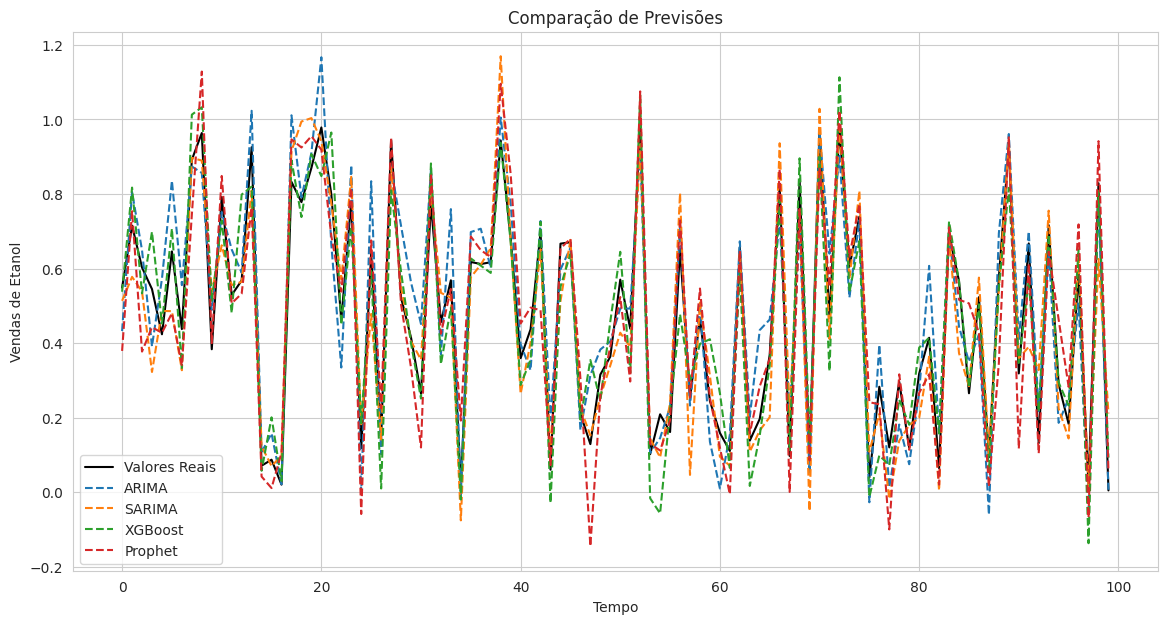

In [30]:
plt.figure(figsize=(14, 7))

# Valores Reais
plt.plot(y_true, label='Valores Reais', color='black')

# Previsões dos Modelos
plt.plot(y_pred_arima, label='ARIMA', linestyle='--')
plt.plot(y_pred_sarima, label='SARIMA', linestyle='--')
plt.plot(y_pred_xgb, label='XGBoost', linestyle='--')
plt.plot(y_pred_prophet, label='Prophet', linestyle='--')

plt.title('Comparação de Previsões')
plt.xlabel('Tempo')
plt.ylabel('Vendas de Etanol')
plt.legend()
plt.show()